In [1]:
import numpy as np
from PIL import Image
from io import BytesIO
from IPython.display import display
import os
from google.cloud import vision
from tqdm.notebook import tqdm
import webcolors
import hashlib

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.abspath(os.path.join(os.getcwd(), 'config/sideb-proejct-0e33d8c0b0a9.json'))

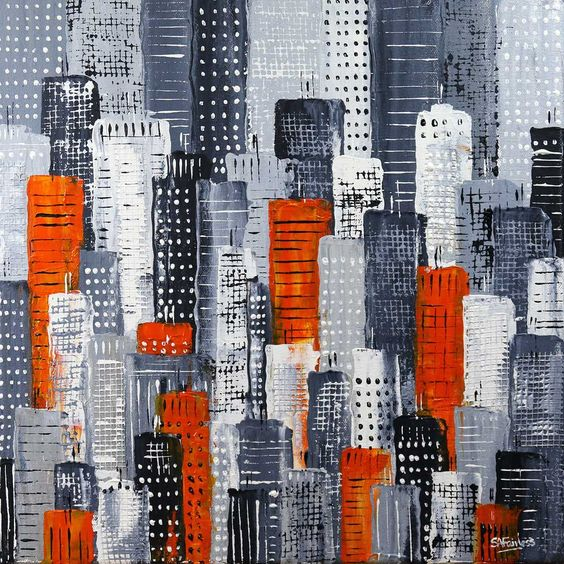

In [3]:
img_path = 'imgs/city.jpg'

with open(img_path, 'rb') as img_file:
    content = img_file.read()
    
image = vision.Image(content=content)
Image.open(BytesIO(content))

# Label annotation

In [4]:
client = vision.ImageAnnotatorClient()
# image = vision.Image(content=req.get(imgs[0], allow_redirects=True).content)
resp_label = client.label_detection(image=image, max_results=50)
labels = resp_label.label_annotations
labels = [label.description.lower().replace(' ', '_') for label in labels if label.score>=0.6]
' '.join(labels)

'skyscraper building orange tower_block art world urban_design font city cityscape tints_and_shades pattern metropolitan_area symmetry composite_material metropolis urban_area rectangle space facade mixed-use downtown condominium visual_arts paint creative_arts'

# Source finder

In [5]:
resp_web = client.web_detection(image=image)
resp_web.web_detection.full_matching_images[0].url

'https://i.pinimg.com/originals/8a/19/ef/8a19effe3c2d6903a0684709622de62f.jpg'

# RGB to color name
* https://webcolors.readthedocs.io/en/1.12/contents.html#specification-identifiers
* https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python

In [13]:
def closest_color(requested_color):
    min_colors = {}
    
    for key, name in webcolors.CSS21_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
        
    return min_colors[min(min_colors.keys())]

def get_color_name(requested_color):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_color, spec='css21')
        
    except ValueError:
        closest_name = closest_color(requested_color)
        actual_name = None
        
    # return actual_name, closest_name
    return closest_name


# requested_colour = (0, 0, 0)
# actual_name, closest_name = get_colour_name(requested_colour)
# actual_name, closest_name

# Color extraction

In [16]:
resp_props = client.image_properties(image=image)
dom_colors = resp_props.image_properties_annotation.dominant_colors.colors
dom_colors

[color {
  red: 200.0
  green: 67.0
  blue: 19.0
}
score: 0.27325525879859924
pixel_fraction: 0.02851414494216442
, color {
  red: 144.0
  green: 55.0
  blue: 24.0
}
score: 0.06009400263428688
pixel_fraction: 0.015872132033109665
, color {
  red: 190.0
  green: 191.0
  blue: 198.0
}
score: 0.04360523819923401
pixel_fraction: 0.1772109568119049
, color {
  red: 76.0
  green: 82.0
  blue: 101.0
}
score: 0.022657716646790504
pixel_fraction: 0.08788149058818817
, color {
  red: 119.0
  green: 72.0
  blue: 58.0
}
score: 0.01002192310988903
pixel_fraction: 0.008576520718634129
, color {
  red: 172.0
  green: 43.0
  blue: 4.0
}
score: 0.24536363780498505
pixel_fraction: 0.024782802909612656
, color {
  red: 158.0
  green: 58.0
  blue: 9.0
}
score: 0.03168473392724991
pixel_fraction: 0.006348852533847094
, color {
  red: 159.0
  green: 159.0
  blue: 166.0
}
score: 0.028719695284962654
pixel_fraction: 0.11394520103931427
, color {
  red: 186.0
  green: 83.0
  blue: 30.0
}
score: 0.0250398721545

In [8]:
sorted(dom_colors, key=lambda x: -x.score);

In [14]:
pct_thres = 0.6
pct_cum = 0
colors = []
score_sum = sum([clr.score for clr in dom_colors])

for clr in sorted(dom_colors, key=lambda x: -x.score):
    if pct_cum > pct_thres: 
        break
        
    pct_cum += (clr.score / score_sum)
    colors.append(
        #(int(clr.color.red), int(clr.color.green), int(clr.color.blue))
        get_color_name((clr.color.red, clr.color.green, clr.color.blue))
    )
    
' '.join(colors)

'red maroon'

# SHA256 hashing

In [15]:
_img = Image.open(img_path).convert('RGB')
_img_array = np.array(_img).astype(np.uint16)
_img_bytes = _img_array.tobytes()
hashlib.sha256(_img_bytes).hexdigest()

'8055a70bfec3bf27d69955cf149079e0c3aabc23db08f7eb19c0fad84c31992c'